# Introduction

Do higher film budgets lead to more box office revenue? Let's find out if there's a relationship using the movie budgets and financial performance data that I've scraped from [the-numbers.com](https://www.the-numbers.com/movie/budgets) on **May 1st, 2018**. 

<img src=https://i.imgur.com/kq7hrEh.png>

# Import Statements

In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Notebook Presentation

In [38]:
pd.options.display.float_format = '{:,.2f}'.format

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Read the Data

In [25]:
data = pd.read_csv('cost_revenue_dirty.csv')

# Explore and Clean the Data

**Challenge**: Answer these questions about the dataset:
1. How many rows and columns does the dataset contain?
2. Are there any NaN values present?
3. Are there any duplicate rows?
4. What are the data types of the columns?

In [4]:
data.head()

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
0,5293,8/2/1915,The Birth of a Nation,"$110,000","$11,000,000","$10,000,000"
1,5140,5/9/1916,Intolerance,"$385,907",$0,$0
2,5230,12/24/1916,"20,000 Leagues Under the Sea","$200,000","$8,000,000","$8,000,000"
3,5299,9/17/1920,Over the Hill to the Poorhouse,"$100,000","$3,000,000","$3,000,000"
4,5222,1/1/1925,The Big Parade,"$245,000","$22,000,000","$11,000,000"


In [5]:
data.shape

(5391, 6)

In [35]:
data.isna().values.any()

False

In [36]:
data.duplicated().values.any()

False

In [19]:
data.dtypes

Rank                      int64
Release_Date             object
Movie_Title              object
USD_Production_Budget    object
USD_Worldwide_Gross      object
USD_Domestic_Gross       object
dtype: object

### Data Type Conversions

**Challenge**: Convert the `USD_Production_Budget`, `USD_Worldwide_Gross`, and `USD_Domestic_Gross` columns to a numeric format by removing `$` signs and `,`. 
<br>
<br>
Note that *domestic* in this context refers to the United States.

In [26]:
convertion_columns = ["USD_Production_Budget", "USD_Worldwide_Gross", "USD_Domestic_Gross"]
for column in convertion_columns:
    data[column] = data[column].str.replace("$","")
    data[column] = data[column].str.replace(",","")
    data[column] = pd.to_numeric(data[column])
    
data.dtypes

C:\Users\filip\AppData\Local\Temp\ipykernel_19104\3993346945.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data[column] = data[column].str.replace("$","")


Rank                      int64
Release_Date             object
Movie_Title              object
USD_Production_Budget     int64
USD_Worldwide_Gross       int64
USD_Domestic_Gross        int64
dtype: object

**Challenge**: Convert the `Release_Date` column to a Pandas Datetime type. 

In [33]:
data.Release_Date = pd.to_datetime(data.Release_Date, format="%m/%d/%Y")
data.dtypes

Rank                              int64
Release_Date             datetime64[ns]
Movie_Title                      object
USD_Production_Budget             int64
USD_Worldwide_Gross               int64
USD_Domestic_Gross                int64
dtype: object

### Descriptive Statistics

**Challenge**: 

1. What is the average production budget of the films in the data set?
2. What is the average worldwide gross revenue of films?
3. What were the minimums for worldwide and domestic revenue?
4. Are the bottom 25% of films actually profitable or do they lose money?
5. What are the highest production budget and highest worldwide gross revenue of any film?
6. How much revenue did the lowest and highest budget films make?

In [60]:
data.describe()

,Rank,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
count,"5,391.00","5,391.00","5,391.00","5,391.00"
mean,"2,696.00","31,113,737.58","88,855,421.96","41,235,519.44"
std,"1,556.39","40,523,796.88","168,457,757.00","66,029,346.27"
min,1.00,"1,100.00",0.00,0.00
25%,"1,348.50","5,000,000.00","3,865,206.00","1,330,901.50"
50%,"2,696.00","17,000,000.00","27,450,453.00","17,192,205.00"
75%,"4,043.50","40,000,000.00","96,454,455.00","52,343,687.00"
max,"5,391.00","425,000,000.00","2,783,918,982.00","936,662,225.00"


In [45]:
print(f"Average budget: ${data.USD_Production_Budget.mean()}")
print(f"Average worldwide gross revenue: ${data.USD_Worldwide_Gross.mean()}")
print(f"Minimum worldwide revenue: ${data.USD_Worldwide_Gross.min()}")
print(f"Minimum domestic revenue: ${data.USD_Domestic_Gross.min()}")

Average budget: $31113737.57837136
Average worldwide gross revenue: $88855421.96271564
Minimum worldwide revenue: $0
Minimum domestic revenue: $0


In [61]:
bot_25_rev = data.USD_Worldwide_Gross.quantile(0.25)
bot_25_budg = data.USD_Production_Budget.quantile(0.25)
print(f"Bottom 25% of films budget: ${bot_25_budg}")
print(f"Bottom 25% of filmes revenue: ${bot_25_rev}")
print(f"Profit/Loss: ${bot_25_rev-bot_25_budg}")

Bottom 25% of films budget: $5000000.0
Bottom 25% of filmes revenue: $3865206.0
Profit/Loss: $-1134794.0


In [49]:
print(f"Highest worldwide revenue: ${data.USD_Worldwide_Gross.max()}")
print(f"Highest production budget: ${data.USD_Production_Budget.max()}")

Highest worldwide revenue: $2783918982
Highest production budget: $425000000


In [51]:
highest_budget_film = data.USD_Production_Budget.idxmax()
lowest_budget_film = data.USD_Production_Budget.idxmin()

print(f"Highest budget film revenue: ${data.USD_Worldwide_Gross[highest_budget_film]}")
print(f"Lowest budget film revenue: ${data.USD_Worldwide_Gross[lowest_budget_film]}")

Highest budget film revenue: $2783918982
Lowest budget film revenue: $181041


# Investigating the Zero Revenue Films

**Challenge** How many films grossed $0 domestically (i.e., in the United States)? What were the highest budget films that grossed nothing?

In [58]:
gross_0_domestic = data[data.USD_Domestic_Gross == 0]
print(f"Number of films with $0 domestic gross: {len(gross_0_domestic)}")
gross_0_domestic.sort_values("USD_Production_Budget", ascending=False).head(5)

Number of films with $0 domestic gross: 512


,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
5388,96,2020-12-31,Singularity,175000000,0,0
5387,126,2018-12-18,Aquaman,160000000,0,0
5384,321,2018-09-03,A Wrinkle in Time,103000000,0,0
5385,366,2018-10-08,Amusement Park,100000000,0,0
5090,556,2015-12-31,"Don Gato, el inicio de la pandilla",80000000,4547660,0


**Challenge**: How many films grossed $0 worldwide? What are the highest budget films that had no revenue internationally?

In [59]:
gross_0_inter = data[data.USD_Worldwide_Gross == 0]
print(f"Number of films with $0 domestic gross: {len(gross_0_inter.values)}")
gross_0_inter.sort_values("USD_Production_Budget", ascending=False).head(5)

Number of films with $0 domestic gross: 357


,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
5388,96,2020-12-31,Singularity,175000000,0,0
5387,126,2018-12-18,Aquaman,160000000,0,0
5384,321,2018-09-03,A Wrinkle in Time,103000000,0,0
5385,366,2018-10-08,Amusement Park,100000000,0,0
5058,880,2015-11-12,The Ridiculous 6,60000000,0,0


### Filtering on Multiple Conditions

In [64]:
international_releases = data.loc[(data.USD_Domestic_Gross == 0) & (data.USD_Worldwide_Gross != 0)]
print(f"Number of international releases: {len(international_releases)}")
international_releases.head()

Number of international releases: 155


,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
71,4310,1956-02-16,Carousel,3380000,3220,0
1579,5087,2001-02-11,Everything Put Together,500000,7890,0
1744,3695,2001-12-31,The Hole,7500000,10834406,0
2155,4236,2003-12-31,Nothing,4000000,63180,0
2203,2513,2004-03-31,The Touch,20000000,5918742,0


**Challenge**: Use the [`.query()` function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.query.html) to accomplish the same thing. Create a subset for international releases that had some worldwide gross revenue, but made zero revenue in the United States. 

Hint: This time you'll have to use the `and` keyword.

In [68]:
data.query('USD_Domestic_Gross == 0 and USD_Worldwide_Gross != 0')

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
71,4310,1956-02-16,Carousel,3380000,3220,0
1579,5087,2001-02-11,Everything Put Together,500000,7890,0
1744,3695,2001-12-31,The Hole,7500000,10834406,0
2155,4236,2003-12-31,Nothing,4000000,63180,0
2203,2513,2004-03-31,The Touch,20000000,5918742,0
...,...,...,...,...,...,...
5340,1506,2017-04-14,Queen of the Desert,36000000,1480089,0
5348,2225,2017-05-05,Chāi dàn zhuānjiā,23000000,58807172,0
5360,4832,2017-07-03,Departure,1100000,27561,0
5372,1856,2017-08-25,Ballerina,30000000,48048527,0


### Unreleased Films

**Challenge**:
* Identify which films were not released yet as of the time of data collection (May 1st, 2018).
* How many films are included in the dataset that have not yet had a chance to be screened in the box office? 
* Create another DataFrame called data_clean that does not include these films. 

In [69]:
# Date of Data Collection
scrape_date = pd.Timestamp('2018-5-1')

In [73]:
recent_films = data[data.Release_Date >= scrape_date]
print(f"Films released after 2018-05-01: {len(recent_films)}")

data_clean = data.drop(recent_films.index)

Films released after 2018-05-01: 7


### Films that Lost Money

**Challenge**: 
What is the percentage of films where the production costs exceeded the worldwide gross revenue? 

In [80]:
lost_money = data_clean[data_clean.USD_Production_Budget > data_clean.USD_Worldwide_Gross]
print(f"Percentage of films that lost money: {len(lost_money)/len(data)*100}")

Percentage of films that lost money: 37.228714524207014


# Seaborn for Data Viz: Bubble Charts

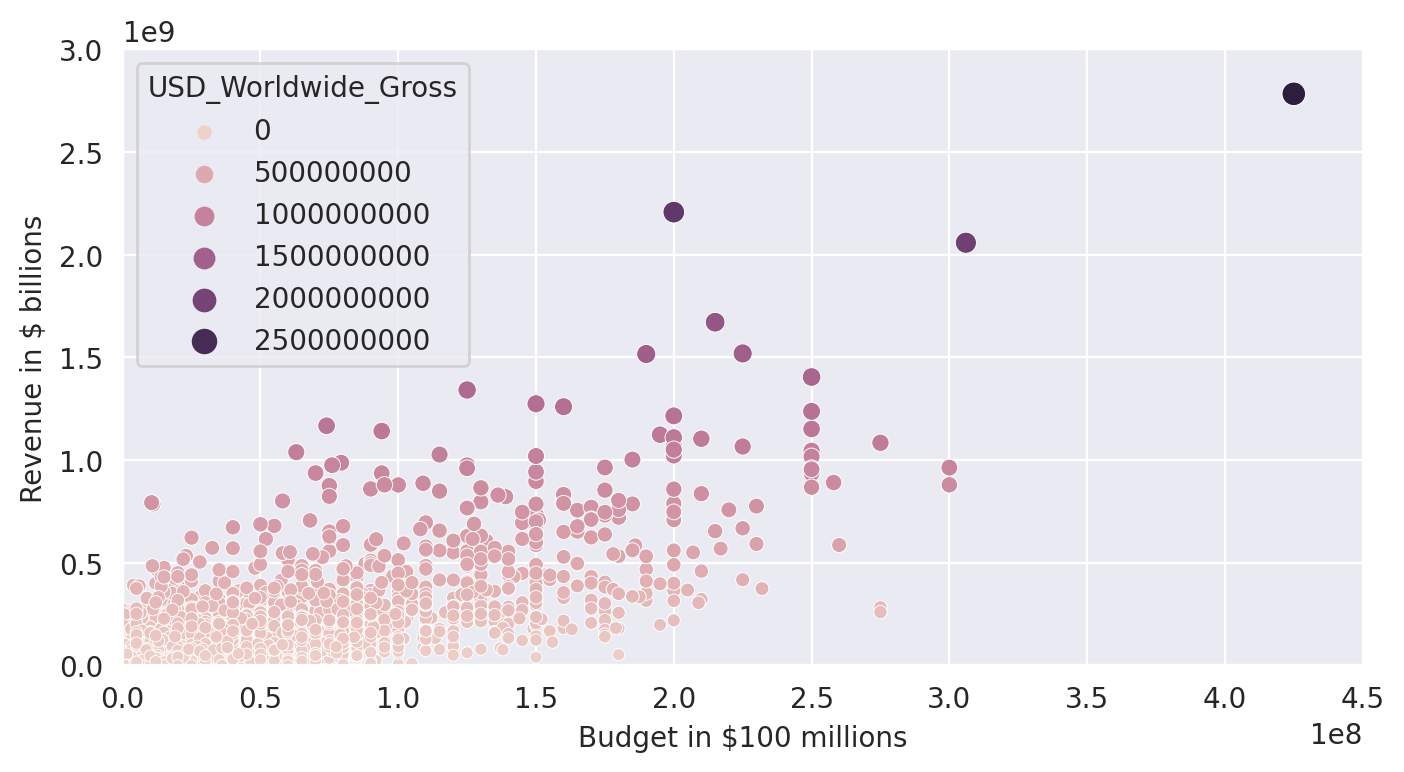

In [89]:
plt.figure(figsize=(8,4), dpi=200)
 
# set styling on a single chart
with sns.axes_style('darkgrid'):
  ax = sns.scatterplot(data=data_clean,
                       x='USD_Production_Budget', 
                       y='USD_Worldwide_Gross',
                       hue='USD_Worldwide_Gross',
                       size='USD_Worldwide_Gross')
 
  ax.set(ylim=(0, 3000000000),
        xlim=(0, 450000000),
        ylabel='Revenue in $ billions',
        xlabel='Budget in $100 millions')
 
plt.show()

### Plotting Movie Releases over Time

**Challenge**: Try to create the following Bubble Chart:

<img src=https://i.imgur.com/8fUn9T6.png>



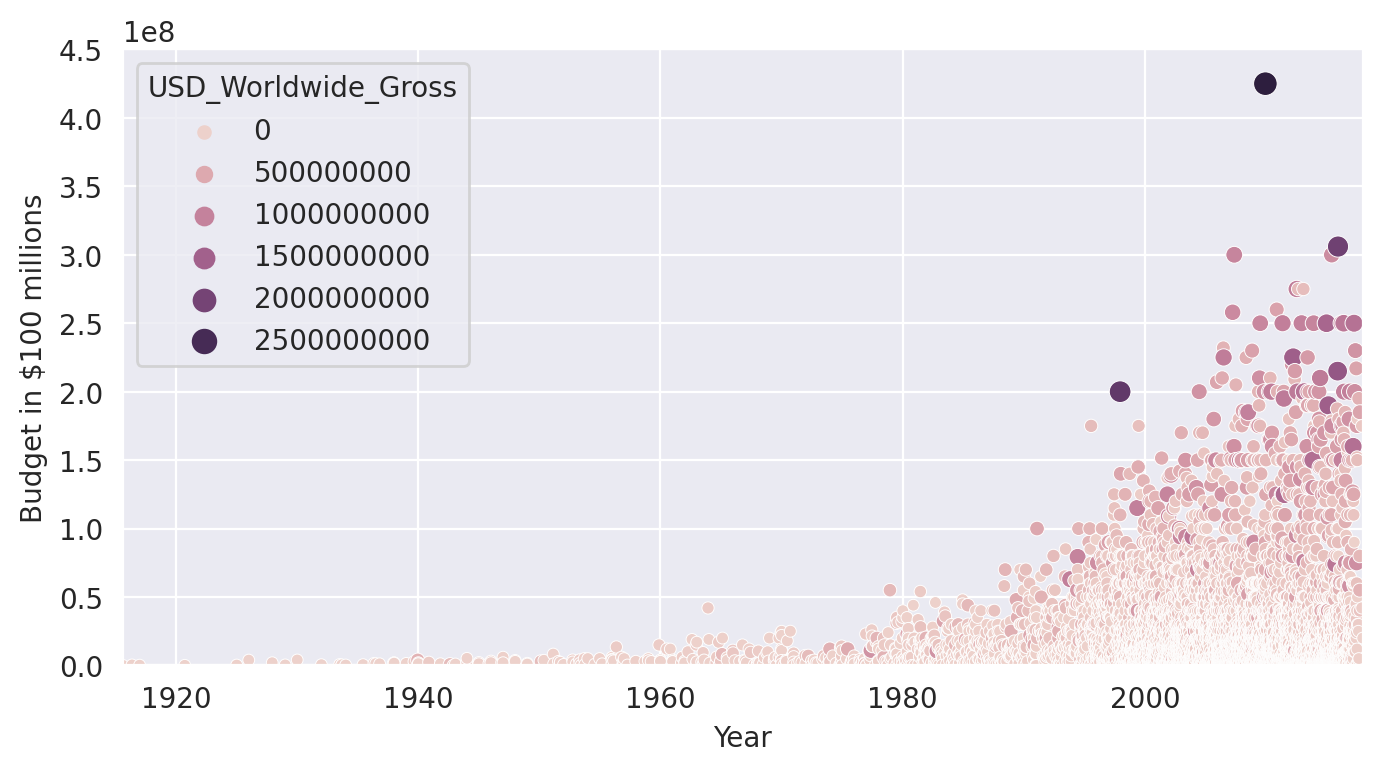

In [92]:
plt.figure(figsize=(8,4), dpi=200)
 
# set styling on a single chart
with sns.axes_style('darkgrid'):
  ax = sns.scatterplot(data=data_clean,
                       x='Release_Date', 
                       y='USD_Production_Budget',
                       hue='USD_Worldwide_Gross',
                       size='USD_Worldwide_Gross')
 
  ax.set(ylim=(0, 450000000),
        xlim=(data_clean.Release_Date.min(), data_clean.Release_Date.max()),
        ylabel='Budget in $100 millions',
        xlabel='Year')
 
plt.show()

# Converting Years to Decades Trick

**Challenge**: Create a column in `data_clean` that has the decade of the release. 

<img src=https://i.imgur.com/0VEfagw.png width=650> 

Here's how: 
1. Create a [`DatetimeIndex` object](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html) from the Release_Date column. 
2. Grab all the years from the `DatetimeIndex` object using the `.year` property.
<img src=https://i.imgur.com/5m06Ach.png width=650>
3. Use floor division `//` to convert the year data to the decades of the films.
4. Add the decades as a `Decade` column to the `data_clean` DataFrame.

In [103]:
decades = pd.DatetimeIndex(data_clean.Release_Date).year // 10 * 10
data_clean["Decades"] = decades
data_clean

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross,Decades
0,5293,1915-08-02,The Birth of a Nation,110000,11000000,10000000,1910
1,5140,1916-05-09,Intolerance,385907,0,0,1910
2,5230,1916-12-24,"20,000 Leagues Under the Sea",200000,8000000,8000000,1910
3,5299,1920-09-17,Over the Hill to the Poorhouse,100000,3000000,3000000,1920
4,5222,1925-01-01,The Big Parade,245000,22000000,11000000,1920
...,...,...,...,...,...,...,...
5379,1295,2017-10-02,John Wick: Chapter Two,40000000,166893990,92029184,2010
5380,70,2017-10-03,Kong: Skull Island,185000000,561137727,168052812,2010
5381,94,2017-12-05,King Arthur: Legend of the Sword,175000000,140012608,39175066,2010
5382,1254,2017-12-05,Snatched,42000000,57850343,45850343,2010


### Separate the "old" (before 1969) and "New" (1970s onwards) Films

**Challenge**: Create two new DataFrames: `old_films` and `new_films`
* `old_films` should include all the films before 1969 (up to and including 1969)
* `new_films` should include all the films from 1970 onwards
* How many films were released prior to 1970?
* What was the most expensive film made prior to 1970?

In [114]:
old_films = data_clean[data_clean.Decades < 1970]
new_films = data_clean[data_clean.Decades >= 1970]

print(f"Films prior to 1970: {len(old_films)}")
print(f"Most expensive film prior to 1970: {old_films.iloc[[old_films.USD_Production_Budget.idxmax()]]}")

Films prior to 1970: 153
Most expensive film prior to 1970:      Rank Release_Date Movie_Title  USD_Production_Budget  \
109  1253   1963-12-06   Cleopatra               42000000   

     USD_Worldwide_Gross  USD_Domestic_Gross  Decades  
109             71000000            57000000     1960  


# Seaborn Regression Plots

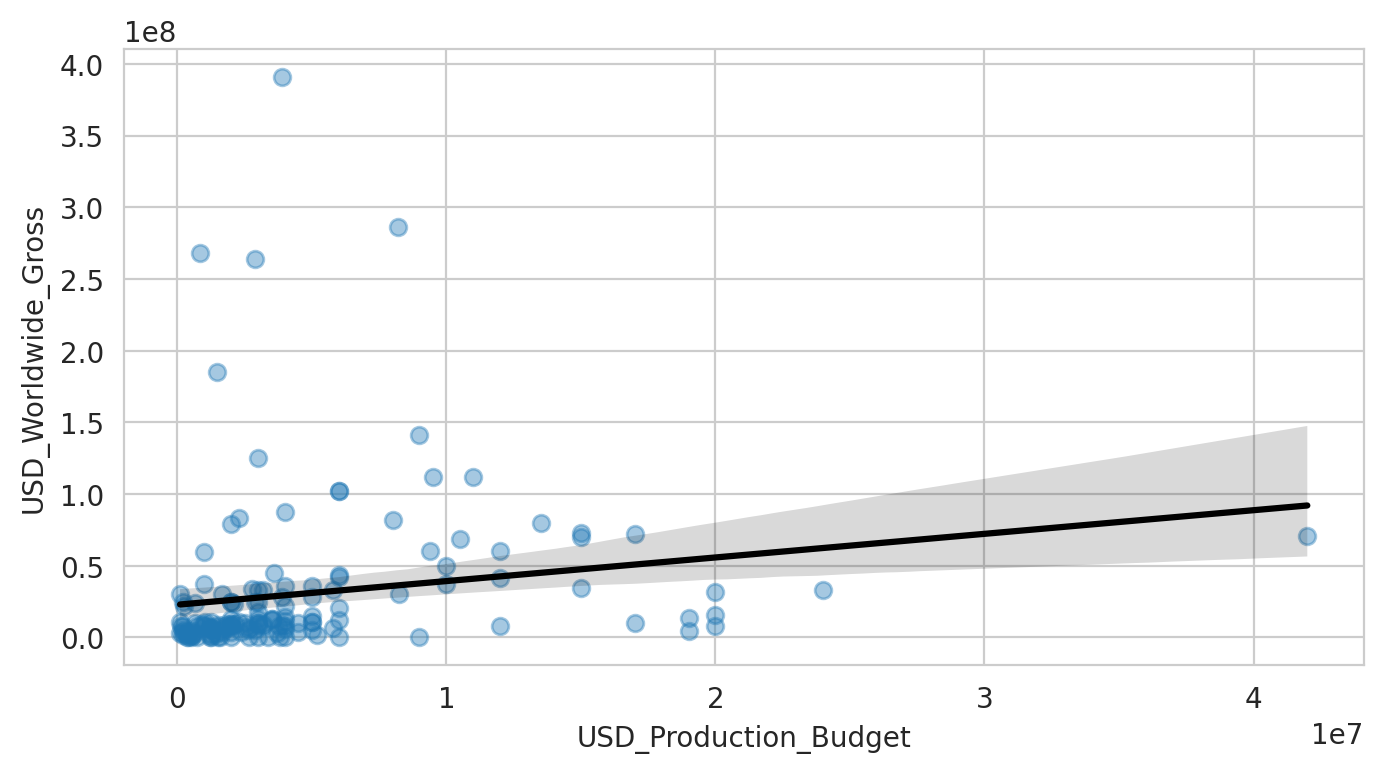

In [115]:
plt.figure(figsize=(8,4), dpi=200)
with sns.axes_style("whitegrid"):
    sns.regplot(data=old_films, 
            x='USD_Production_Budget', 
            y='USD_Worldwide_Gross',
            scatter_kws = {'alpha': 0.4},
            line_kws = {'color': 'black'})

**Challenge**: Use Seaborn's `.regplot()` to show the scatter plot and linear regression line against the `new_films`. 
<br>
<br>
Style the chart

* Put the chart on a `'darkgrid'`.
* Set limits on the axes so that they don't show negative values.
* Label the axes on the plot "Revenue in \$ billions" and "Budget in \$ millions".
* Provide HEX colour codes for the plot and the regression line. Make the dots dark blue (#2f4b7c) and the line orange (#ff7c43).

Interpret the chart

* Do our data points for the new films align better or worse with the linear regression than for our older films?
* Roughly how much would a film with a budget of $150 million make according to the regression line?

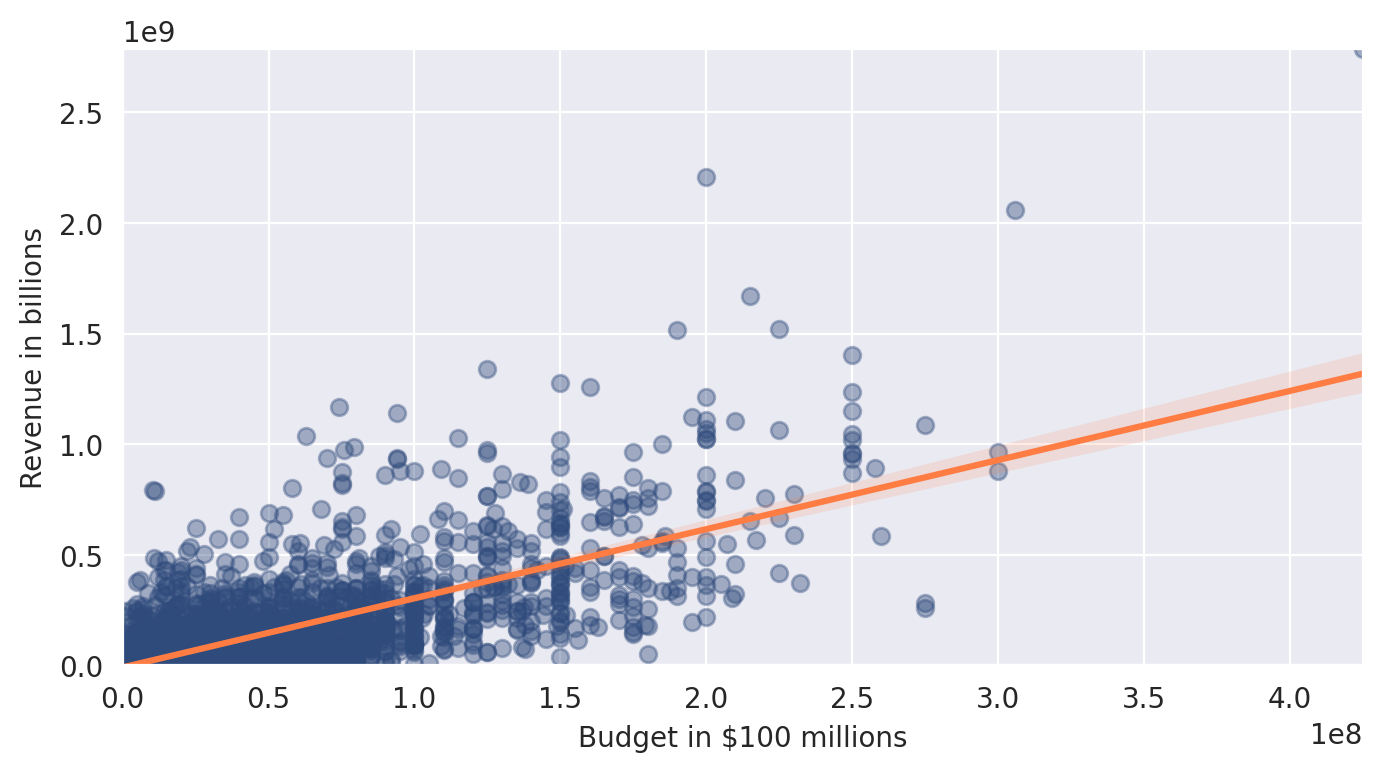

In [123]:
plt.figure(figsize=(8,4), dpi=200)
with sns.axes_style("darkgrid"):
  ax = sns.regplot(data=new_films, 
            x='USD_Production_Budget', 
            y='USD_Worldwide_Gross',
            color="#2f4b7c",
            scatter_kws = {'alpha': 0.4},
            line_kws = {'color': '#ff7c43'})

  ax.set(ylim=(0, new_films.USD_Worldwide_Gross.max()),
        xlim=(0, new_films.USD_Production_Budget.max()),
        ylabel='Revenue in billions',
        xlabel='Budget in $100 millions')

# Run Your Own Regression with scikit-learn

$$ REV \hat ENUE = \theta _0 + \theta _1 BUDGET$$

In [125]:
regression = LinearRegression()

# Explanatory Variable(s) or Feature(s)
X = pd.DataFrame(new_films, columns=['USD_Production_Budget'])
 
# Response Variable or Target
y = pd.DataFrame(new_films, columns=['USD_Worldwide_Gross']) 

# Find the best-fit line
regression.fit(X, y)

LinearRegression()

In [126]:
regression.intercept_

array([-8650768.0066103])

In [127]:
regression.coef_

array([[3.12259592]])

In [128]:
# R-squared
regression.score(X, y)

0.5577032617720403

**Challenge**: Run a linear regression for the `old_films`. Calculate the intercept, slope and r-squared. How much of the variance in movie revenue does the linear model explain in this case?

In [129]:
regression_oldfilms = LinearRegression()

# Explanatory Variable(s) or Feature(s)
X_old = pd.DataFrame(old_films, columns=['USD_Production_Budget'])
 
# Response Variable or Target
y_old = pd.DataFrame(old_films, columns=['USD_Worldwide_Gross']) 

# Find the best-fit line
regression_oldfilms.fit(X_old, y_old)

LinearRegression()

In [130]:
print(f"Intercept: {regression_oldfilms.intercept_}")
print(f"Coeficient: {regression_oldfilms.coef_}")
print(f"Score: {regression_oldfilms.score(X_old, y_old)}")

Intercept: [22821538.63508038]
Coeficient: [[1.64771314]]
Score: 0.02937258620576877


# Use Your Model to Make a Prediction

We just estimated the slope and intercept! Remember that our Linear Model has the following form:

$$ REV \hat ENUE = \theta _0 + \theta _1 BUDGET$$

**Challenge**:  How much global revenue does our model estimate for a film with a budget of $350 million? 

In [137]:
budget = 350000000
revenue_estimate = regression_oldfilms.intercept_[0] + regression_oldfilms.coef_[0,0]*budget
revenue_estimate = round(revenue_estimate, -6)
print(f'The estimated revenue for a $350 film is around ${revenue_estimate:.10}.')

The estimated revenue for a $350 film is around $600000000.0.
